In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.optim

# CODE FILES HERE
from examples.vae.vae import Encoder, Decoder, Vae, PATH
from solver import Solver
from dataloader import DataLoader
from plot import plot_losses, plot_gauss_distributions, plot_rl_kl, plot_latent_space, plot_latent_manifold, plot_faces_grid, plot_faces_samples_grid

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [3]:
batch_size = 128
optimizer = torch.optim.Adam

In [73]:
# Choose the dataset and tune hyperparameters here!
dataset = "MNIST"

if dataset == "MNIST" or dataset == "EMNIST":
    epochs = 8
    hidden_dim = 500 # Kingma, Welling use 500 neurons, otherwise use 400
    z_dim = 2
    step_config = {
        "step_size" : -1,
        "gamma" : 0.1
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": 0
    }
elif dataset == "LFW":
    epochs = 200
    hidden_dim = 700 # 200 in Kingma for Frey Face but we have highly varying data!
    z_dim = 2
    step_config = {
        "step_size" : 50,
        "gamma" : 0.1
    }
    optim_config = {
        "lr": 1e-2,
        "weight_decay": 1e-4
    }
elif dataset == "FF":
    epochs = 50 # 200 for zdim=20, 500 for zdim=2
    hidden_dim = 200 # as in Kingma
    z_dim = 2
    step_config = {
        "step_size" : 100,
        "gamma" : 0.1
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": 0
    }

In [74]:
data_loader = DataLoader(PATH, batch_size, dataset, z_dim)
encoder = Encoder(data_loader.input_dim, hidden_dim, z_dim)
decoder = Decoder(z_dim, hidden_dim, data_loader.input_dim)
model = Vae(encoder, decoder)

In [75]:
solver = Solver(model, data_loader, optimizer, z_dim, epochs, step_config, optim_config)
solver.run()

+++++ START RUN +++++
====> Epoch: 1 train set loss avg: 186.2843
====> Test set loss avg: 183.5574
34.12949228286743 seconds for epoch 1
====> Epoch: 2 train set loss avg: 165.5653
====> Test set loss avg: 179.9486
41.40316653251648 seconds for epoch 2
====> Epoch: 3 train set loss avg: 161.5985
====> Test set loss avg: 179.4370
45.136497259140015 seconds for epoch 3
====> Epoch: 4 train set loss avg: 159.3440
====> Test set loss avg: 178.5027
48.65514087677002 seconds for epoch 4
====> Epoch: 5 train set loss avg: 157.8100
====> Test set loss avg: 178.4626
50.34917759895325 seconds for epoch 5
====> Epoch: 6 train set loss avg: 156.6810
====> Test set loss avg: 176.0607
48.49587440490723 seconds for epoch 6
====> Epoch: 7 train set loss avg: 155.7188
====> Test set loss avg: 178.7509
51.24814033508301 seconds for epoch 7
====> Epoch: 8 train set loss avg: 154.8866
====> Test set loss avg: 178.0244
49.04973912239075 seconds for epoch 8
+++++ RUN IS FINISHED +++++


In [ ]:
# Insert name of model here if want to load a model
#solver = torch.load("../models/VAE_MNIST_train_loss=151.39_z=2.pt")
#solver.model.eval()

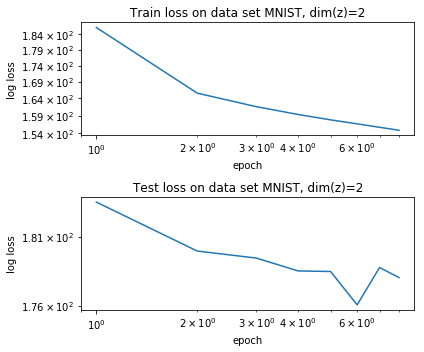

In [78]:
# Plotting train and test losses for all epochs
plot_losses(solver)

epoch: 1, mu(z): 0.3913, stddev(z): 1.7244, var(z): 2.9735, var(mu(z)): 1.5756 E[var(q(z|x)]: 0.0535
epoch: 3, mu(z): 0.1609, stddev(z): 1.3733, var(z): 1.8861, var(mu(z)): 1.7187 E[var(q(z|x)]: 0.0004
epoch: 5, mu(z): 0.1340, stddev(z): 1.3100, var(z): 1.7162, var(mu(z)): 1.6218 E[var(q(z|x)]: 0.0002
epoch: 7, mu(z): 0.1190, stddev(z): 1.2761, var(z): 1.6283, var(mu(z)): 1.5603 E[var(q(z|x)]: 0.0001


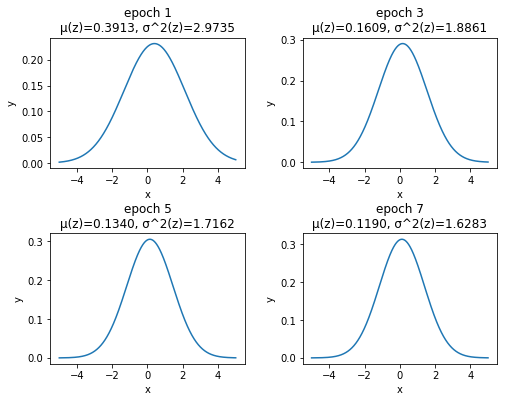

In [85]:
# Plotting histogram of the latent space's distribution, given the computed \mu and \sigma
num_plots = 4
plot_gauss_distributions(solver, num_plots)

epoch: 1, train_loss: 186.28, test_loss: 183.56, recon. loss: 180.68, KL div.: 5.60
overfitting: 2.73
epoch: 2, train_loss: 165.57, test_loss: 179.95, recon. loss: 160.28, KL div.: 5.28
overfitting: 14.38
epoch: 3, train_loss: 161.60, test_loss: 179.44, recon. loss: 156.17, KL div.: 5.43
overfitting: 17.84
epoch: 4, train_loss: 159.34, test_loss: 178.50, recon. loss: 153.83, KL div.: 5.52
overfitting: 19.16
epoch: 5, train_loss: 157.81, test_loss: 178.46, recon. loss: 152.22, KL div.: 5.59
overfitting: 20.65
epoch: 6, train_loss: 156.68, test_loss: 176.06, recon. loss: 151.04, KL div.: 5.64
overfitting: 19.38
epoch: 7, train_loss: 155.72, test_loss: 178.75, recon. loss: 150.04, KL div.: 5.68
overfitting: 23.03
epoch: 8, train_loss: 154.89, test_loss: 178.02, recon. loss: 149.16, KL div.: 5.72
overfitting: 23.14


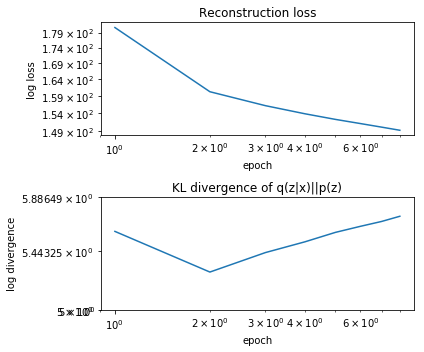

In [87]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
for ((epoch, train_loss, rl, kl), test_loss) in zip(solver.train_loss_history, solver.test_loss_history):
    print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(epoch, train_loss, test_loss, rl, kl))
    print("overfitting: {:.2f}".format(abs(test_loss-train_loss)))
plot_rl_kl(solver)

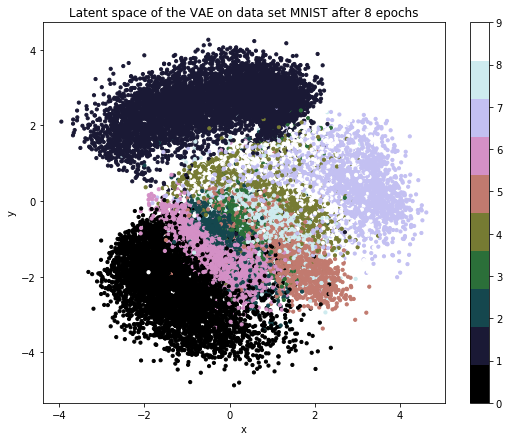

In [88]:
# visualize q(z|x) (latent space z)
if solver.z_dim == 2 and solver.loader.dataset != "FF":
    plot_latent_space(solver)
else:
    print("Plot of latent space not possible as dimension of z is not 2")

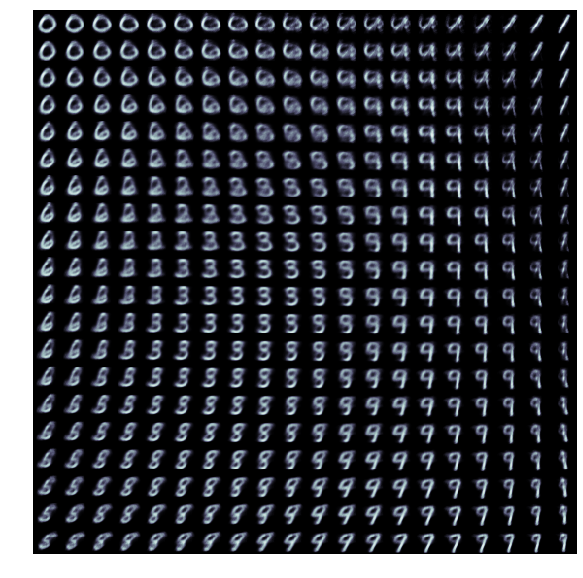

In [89]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if solver.z_dim == 2:
    if solver.loader.dataset == "MNIST":
        plot_latent_manifold(solver, "bone")
    if solver.loader.dataset == "LFW" or solver.loader.dataset == "FF":
        plot_latent_manifold(solver, "gray", n=10, fig_size=(10,8))
else:
    print("Plot is not possible as dimension of z is not 2")

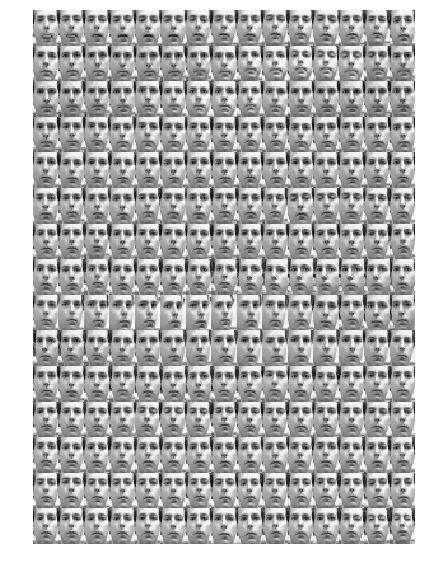

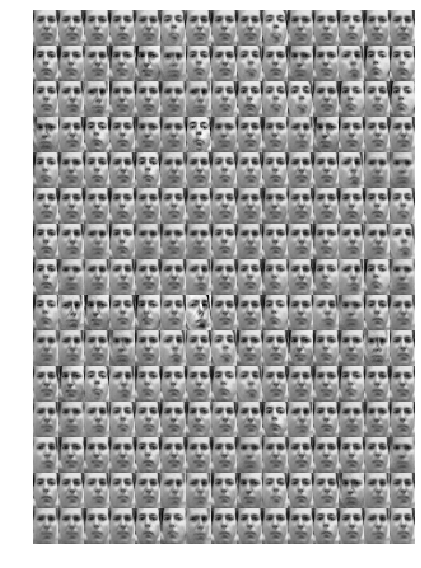

In [71]:
# plots real faces and in grid samples
if dataset == "LFW" or dataset == "FF":
    plot_faces_grid(225, 15, solver)
    plot_faces_samples_grid(225, 15, solver)

In [13]:
avg_train_loss = np.array(list(list(zip(*solver.train_loss_history))[1])).mean()
torch.save(solver, "../models/VAE_" + solver.loader.dataset + "_train_loss=" + "{0:.2f}".format(avg_train_loss) + "_z=" + str(solver.z_dim) + ".pt")